In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install xvfb
None

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 24 not upgraded.
Need to get 892 kB/7,814 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Ign:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 xserver-common all 2:21.1.4-2ubuntu1.7~22.04.2
Ign:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 xvfb amd64 2:21.1.4-2ubuntu1.7~22.04.2
Err:1 http://security.ubuntu.com/ubuntu jammy-updates/main amd64 xserver-common all 2:21.1.4-2ubuntu1.7~22.04.2
  404  Not Found [IP: 91.189.91.82 80]
Err:2 http://security.ubuntu.com/ubunt

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
from pyvirtualdisplay import Display
d = Display(visible=0, size=(400, 300))
d.start()

def show_state(env, episode=0, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Eposide: %d | Step: %d %s" % ('MountainCarContinuous-v0', episode, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

FileNotFoundError: ignored

In [ ]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import random
import pdb;

env = gym.make('MountainCarContinuous-v0', new_step_api = True)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Replay memory**

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Agent**

In [ ]:
class DQN(nn.Module):
    hidden_dim = 128
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, self.hidden_dim)
        self.layer2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        # self.layer3 = nn.Linear(self.hidden_dim, self.hidden_dim)
        # self.layer4 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.layer5 = nn.Linear(self.hidden_dim, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        # x = F.relu(self.layer3(x))
        # x = F.relu(self.layer4(x))
        return self.layer5(x)

    # def load(*args)


In [ ]:
# steps_done = 0

def select_action(state, eps_threshold):
    # global steps_done
    sample = random.random()
    # eps_threshold = EPS_END + (EPS_START - EPS_END) * \
    #     math.exp(-1. * steps_done / EPS_DECAY)
    # steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)#return index of max action
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)# 0 or 1 or 2


def plot_durations(show_result=False):
    plt.figure(1)
    # plt.grid()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    # plt.ylabel('Duration')
    plt.plot(durations_t.numpy(), label = 'Duration')
    plt.plot(scores, label = 'scores')
    # plt.plot(max_speeds, label = 'max speeds')
    plt.legend(loc="upper left")
    plt.plot(ar_150)
    plt.plot(ar_upper_lim)
    plt.plot(ar_epsil, label = "epsilon")
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((200*torch.ones(99), means))
        plt.plot(means.numpy(), label = "Mean duration")

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    # pdb.set_trace()
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)# tensor of false bools of Nones and true of not Nones
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    # print("state_action_values = {}'\n expected_state_action_values = {}".format(state_action_values, expected_state_action_values))
    # print("state: ", state_action_values.shape)
    # print("expected value: ",expected_state_action_values.unsqueeze(1).shape)
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))# 1xbatch_size

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Initialization of agents and learning parameters**

In [ ]:
# PARAMETERS OF LEARNING
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
# BATCH_SIZE = 1024
BATCH_SIZE = 256
GAMMA = 0.9999
# EPS_START = 1
# EPS_END = 0.05
# EPS_DECAY = 0.99
TAU = 0.005
# TAU = 0.5
# LR = 1e-4
LR = 1e-3
# eps_threshold = EPS_START

# Get number of actions from gym action space
# n_actions = env.action_space.n
# n_actions = 2
n_actions = 2
# Get the number of state observations
state= env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

episode_durations = []
scores = []
max_speeds = []
ar_150 = []
ar_upper_lim = []
ar_epsil = []
memory = ReplayMemory(100000)

# **Learning**

Complete


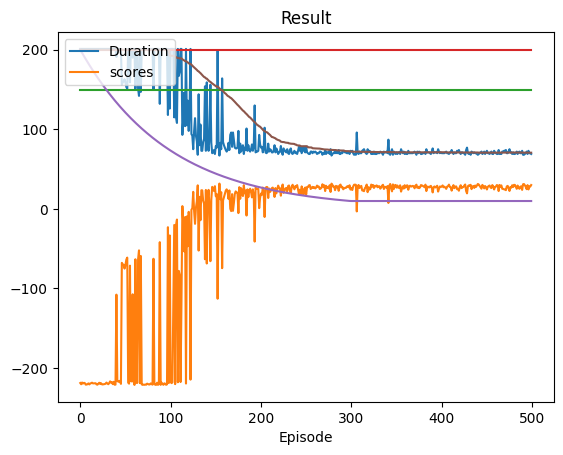

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
num_episodes = 500
EPS_END = 0.05
eps_threshold = 1
# eps_threshold = EPS_END
EPS_DECAY = 0.99
upper_lim = 200
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    score = 0
    max_speed = -100
    for t in count():
        action = select_action(state, eps_threshold)# return tensor([[index_of_max_valuable_action]])
        if(action.item() == 0):
            action_numpy = np.reshape(-1, [1, 1])
        else:
            action_numpy = np.reshape(1, [1, 1])
        observation, reward, terminated, truncated, _ = env.step(action_numpy)
        # show_state(env, i_episode, t)
        if t >= upper_lim:
            truncated = True;
        done = terminated or truncated
        observation = np.reshape(observation, [1, 2])
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)
            reward = 11*reward + 100*(GAMMA*abs(next_state[0][1].item()) - abs(state[0][1].item()))
        score += reward
        reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            print("Time: {}, Position: {}, terminated: {}, done: {}".format(t, observation, terminated, done))
            episode_durations.append(t + 1)
            scores.append(score)
            max_speeds.append(max_speed)
            ar_150.append(150)
            ar_upper_lim.append(upper_lim)
            ar_epsil.append(eps_threshold*upper_lim)
            plot_durations()
            # print('episode: {}/{}, time: {}, score: {}, end_state: {}, reward: {}, epsilon: {}'.format(i_episode, num_episodes, t, score, state, reward, eps_threshold))
            break
    if eps_threshold >= EPS_END:
          eps_threshold *= EPS_DECAY
print('Complete')

output_dir_agent = '/content/drive/MyDrive/RL_mountatin_car'
output_dir_agent_targ = '/content/drive/MyDrive/RL_mountatin_car'
if not os.path.exists(output_dir_agent):
    os.makedirs(output_dir_agent)
output_dir_agent = output_dir_agent + "/agent_after_" + '{:d}'.format(num_episodes) + "_episodes.pt"
output_dir_agent_targ = output_dir_agent_targ + "/agent_targ_after_" + '{:d}'.format(num_episodes) + "_episodes.pt"
torch.save(policy_net.state_dict(), output_dir_agent)
torch.save(target_net.state_dict(), output_dir_agent_targ)

plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_dir_agent = '/content/drive/MyDrive/RL_mountatin_car'
output_dir_agent_targ = '/content/drive/MyDrive/RL_mountatin_car'
if not os.path.exists(output_dir_agent):
    os.makedirs(output_dir_agent)
if not os.path.exists(output_dir_agent_targ):
    os.makedirs(output_dir_agent_targ)
output_dir_agent = output_dir_agent + "/agent_after_" + '{:d}'.format(num_episodes) + "_episodes.pt"
output_dir_agent_targ = output_dir_agent_targ + "/agent_targ_after_" + '{:d}'.format(num_episodes) + "_episodes.pt"

In [ ]:
torch.save(policy_net.state_dict(), output_dir_agent)
torch.save(target_net.state_dict(), output_dir_agent_targ)

# **Тестирование**

In [ ]:
saved_dir_agent = "/content/agent_continuous_mountain_car.pt"
saved_dir_agent_targ = "/content/agent_targ_continuous_mountain_car.pt"

In [ ]:
n_actions = 2 # force: -1, 1
n_observations = 2
agent = DQN(n_observations, n_actions).to(device)
agent.load_state_dict(torch.load(saved_dir_agent))
agent.eval()

In [ ]:
episodes = 5000
not_compl = 0
for i_episode in range(episodes):
    # Initialize the environment and get it's state
    state = env.reset()
    state = torch.tensor(np.transpose(state), dtype=torch.float32, device=device).unsqueeze(0)
    score = 0
    for t in count():
        with torch.no_grad():
          # select_action(state, 0)
          # print(state)
          action = agent(state).max(1).indices.view(1, 1)
        if(action.item() == 0):
            action_numpy = np.reshape(-1, [1, 1])
        else:
            action_numpy = np.reshape(1, [1, 1])
        observation, reward, terminated, truncated, _ = env.step(action_numpy)
        observation = np.reshape(observation, [1,2])
        score += reward
        state = torch.tensor(observation, dtype=torch.float32, device=device)
        # show_state(env, i_episode, t)
        if(terminated or truncated):
          break
    if(observation[0][0] >= 0.45):
      print("+Done:::Episode:", i_episode, ", Time:", t, ", ", score)
    else:
      no_compl += 1
      print("-Notdone:::Episode:", i_episode, ", Time:", t, ", ", score)
      print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
print("Complete episodes = ", episodes - not_compl)
print("Not complete episodes = ", not_compl)


Streaming output truncated to the last 5000 lines.
+Done:::Episode: 2 , Time: 65 ,  93.4
+Done:::Episode: 3 , Time: 69 ,  93.00000000000001
+Done:::Episode: 4 , Time: 66 ,  93.30000000000001
+Done:::Episode: 5 , Time: 66 ,  93.30000000000001
+Done:::Episode: 6 , Time: 67 ,  93.20000000000002
+Done:::Episode: 7 , Time: 69 ,  93.00000000000001
+Done:::Episode: 8 , Time: 66 ,  93.30000000000001
+Done:::Episode: 9 , Time: 66 ,  93.30000000000001
+Done:::Episode: 10 , Time: 67 ,  93.20000000000002
+Done:::Episode: 11 , Time: 67 ,  93.20000000000002
+Done:::Episode: 12 , Time: 66 ,  93.30000000000001
+Done:::Episode: 13 , Time: 66 ,  93.30000000000001
+Done:::Episode: 14 , Time: 66 ,  93.30000000000001
+Done:::Episode: 15 , Time: 67 ,  93.20000000000002
+Done:::Episode: 16 , Time: 65 ,  93.4
+Done:::Episode: 17 , Time: 67 ,  93.20000000000002
+Done:::Episode: 18 , Time: 68 ,  93.10000000000001
+Done:::Episode: 19 , Time: 67 ,  93.20000000000002
+Done:::Episode: 20 , Time: 66 ,  93.3000000000